# Feature Extraction

**In this section we will focus on feature extraction from a single image or the batch of images. For this project our masks (ROI) are already segmented.**

*On average, Pyradiomics extracts ≈1500 features per image, which consist of the 16 shape descriptors and features extracted from original and derived images (LoG with 5 sigma levels, 1 level of Wavelet decomposistions yielding 8 derived images and images derived using Square, Square Root, Logarithm and Exponential filters).*

Detailed description on feature classes and individual features is provided in section [Radiomic Features](https://pyradiomics.readthedocs.io/en/latest/features.html#radiomics-features-label) of the documentation.

This example shows how to use the radiomics package and the feature extractor.
The feature extractor handles preprocessing, and then calls the needed featureclasses to calculate the features.


### Setting up imports

First, import some built-in Python modules needed to get our testing data.
Second, import the toolbox, only the `featureextractor` is needed, this module handles the interaction with other parts of the toolbox.

Here we use `SimpleITK` (referenced as `sitk`, see http://www.simpleitk.org/ for details) to load two brain images and the corresponding segmentations as label maps.

In [2]:
# If you edit a module file, Jupyter’s autoreload extension reloads imported modules:
%load_ext autoreload
%autoreload

%matplotlib inline
import matplotlib.pyplot as plt
import six
import os  # needed navigate the system to get the input data
import SimpleITK as sitk
import logging
import csv
import collections
import radiomics
import pandas
from datetime import datetime
from radiomics import getTestCase
from radiomics import featureextractor, getFeatureClasses

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setting up paths 

In [3]:
# root_path points to the root of the repository. The following line gets that location if this Notebook is run
# from it's default location in \radiomics\thesis-paper\notebooks
root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_path = os.path.join(root_path, "data")
input_path = os.path.join(data_path, 'input-images')
log_path = os.path.join(data_path, 'logs', 'features_extraction_log.txt')

settings_path = os.path.join(root_path, "settings")
output_path = os.path.join(data_path, 'extracted-features')

inputCSV = os.path.join(settings_path, 'batch_test_cases.csv')
params = os.path.join(settings_path, 'Params.yaml')

### Setting up logging


In [3]:
# Get the PyRadiomics logger (default log-level = INFO)
logger = radiomics.logger
logger.setLevel(logging.DEBUG)  # set level to DEBUG to include debug log messages in log file

# Write out all log entries to a file
handler = logging.FileHandler(filename=log_path, mode='w')
formatter = logging.Formatter('%(levelname)s:%(name)s: %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

## Single image

### Setting up data

Test cases can be downloaded to temporary files. This is handled by the `radiomics.getTestCase()` function, which checks if the requested test case is available and if not, downloads it. It returns a tuple with the location of the image and mask of the requested test case, or (None, None) if it fails.

Alternatively, if the data is available somewhere locally, this directory can be passed as a second argument to `radiomics.getTestCase()`. If that directory does not exist or does not contain the testcase, functionality reverts to default and tries to download the test data.

If getting the test case fails, PyRadiomics will log an error explaining the cause.

In [4]:
imagepath_1, labelpath_1 = getTestCase('brain1', input_path)

if imagepath_1 is None or labelpath_1 is None:  # Something went wrong, in this case PyRadiomics will also log an error
    raise Exception('Error getting testcase!')  # Raise exception to prevent cells below from running in case of "run all"
    
image_1 = sitk.ReadImage(imagepath_1)
label_1 = sitk.ReadImage(labelpath_1)

### Show the image

Using `matplotlib.pyplot` (referenced as `plt`), display the images in grayscale and labels in color.

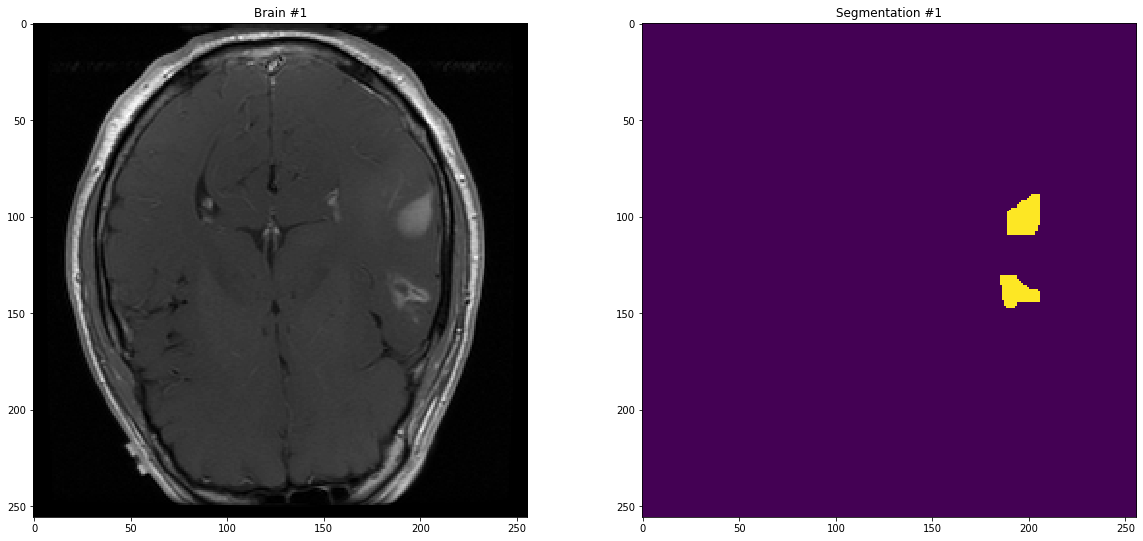

In [5]:
plt.figure(figsize=(20,20))
# First image
plt.subplot(2,2,1)
plt.imshow(sitk.GetArrayFromImage(image_1)[12,:,:], cmap="gray")
plt.title("Brain #1")
plt.subplot(2,2,2)
plt.imshow(sitk.GetArrayFromImage(label_1)[12,:,:])        
plt.title("Segmentation #1")

plt.show()

### Instantiating the extractor

Now that we have our input, we need to define the parameters and instantiate the extractor.
For this there are five possibilities:

**1. Use defaults, don't define custom settings**

```
extractor = featureextractor.RadiomicsFeatureExtractor()
```

**2. Define parameters in a dictionary**

```
# First define the settings
settings = {}
settings['binWidth'] = 20
settings['sigma'] = [1, 2, 3]

# Instantiate the extractor
extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
```

**3. Define parameters in the constructor**

```
extractor = featureextractor.RadiomicsFeatureExtractor(binWidth=20, sigma=[1, 2, 3])
```

**4. Control filters and features after initialisation**

```
extractor.enableImageTypeByName('LoG')

# Disable all feature classes, save firstorder
extractor.disableAllFeatures()
extractor.enableFeatureClassByName('firstorder')

# Specify some additional features in the GLCM feature class
extractor.enableFeaturesByName(glcm=['Autocorrelation', 'Homogeneity1', 'SumSquares'])
```

**5. Use a parameter file**

```
paramsPath = os.path.join('..', 'examples', 'exampleSettings', 'Params.yaml')
extractor = featureextractor.RadiomicsFeatureExtractor(paramsPath)
```

In [6]:
# Instantiate the extractor
if os.path.isfile(params):
    extractor = featureextractor.RadiomicsFeatureExtractor(params)
else:  # Parameter file not found, use hardcoded settings instead
    settings = {}
    settings['binWidth'] = 25
    settings['resampledPixelSpacing'] = None  # [3,3,3]
    settings['interpolator'] = sitk.sitkBSpline
    settings['enableCExtensions'] = True
    
    extractor = featureextractor.RadiomicsFeatureExtractor(**settings)

print('Extraction parameters:')
for setting in extractor.settings.keys():
    print('\t' + setting)
    
print('\nEnabled filters:')
for image_type in extractor.enabledImagetypes.keys():
    print('\t' + image_type)
    
print('\nEnabled features:')
for feature in extractor.enabledFeatures.keys():
    print('\t' + feature)

Extraction parameters:
	minimumROIDimensions
	minimumROISize
	normalize
	normalizeScale
	removeOutliers
	resampledPixelSpacing
	interpolator
	preCrop
	padDistance
	distances
	force2D
	force2Ddimension
	resegmentRange
	label
	additionalInfo
	binWidth
	weightingNorm

Enabled filters:
	Original

Enabled features:
	shape
	firstorder
	glcm
	glrlm
	glszm
	gldm


### Extract features
Now that we have our extractor set up with the correct parameters, we can start extracting features:

In [7]:
result = extractor.execute(image_1, label_1)

In [8]:
print('Result type:', type(result))  # result is returned in a Python ordered dictionary)
print('')
print('Calculated feature')
for key, value in six.iteritems(result):
    print('\t', key, ':', value)

Result type: <class 'collections.OrderedDict'>

Calculated feature
	 diagnostics_Versions_PyRadiomics : v3.0.post2+g896682d
	 diagnostics_Versions_Numpy : 1.17.2
	 diagnostics_Versions_SimpleITK : 1.2.4
	 diagnostics_Versions_PyWavelet : 1.0.0
	 diagnostics_Versions_Python : 3.7.4
	 diagnostics_Configuration_Settings : {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 25, 'weightingNorm': None}
	 diagnostics_Configuration_EnabledImageTypes : {'Original': {}}
	 diagnostics_Image-original_Hash : 5c9ce3ca174f0f8324aa4d277e0fef82dc5ac566
	 diagnostics_Image-original_Dimensionality : 3D
	 diagnostics_Image-original_Spacing : (0.7812499999999999, 0.7812499999999999, 6.499999999999998)
	 diagnostics_Im

## Batch of images

### Setting up data

Read a CSV file that contains paths for the images that we need to process.

*The input file for batch processing is a CSV file where the first row contains headers and each subsequent row represents one combination of an image and a segmentation and contains at least 2 elements: 1) path/to/image, 2) path/to/mask. The headers specify the column names and must be “Image” and “Mask” for image and mask location, respectively (capital sensitive). Additional columns may also be specified, all columns are copied to the output in the same order (with calculated features appended after last column).*

Read more on the [documentation](https://pyradiomics.readthedocs.io/en/latest/usage.html#batch-mode)

In [9]:
logger.info('pyradiomics version: %s', radiomics.__version__)
logger.info('Loading CSV')
try:
    # Use pandas to read and transpose ('.T') the input data
    # The transposition is needed so that each column represents one test case. This is easier for iteration over
    # the input cases
    flists = pandas.read_csv(inputCSV).T
except Exception:
    logger.error('CSV READ FAILED', exc_info=True)
    exit(-1)

logger.info('Loading Done')
logger.info('Patients: %d', len(flists.columns))

In [10]:
flists

,0,1,2,3,4
ID,brain1,brain2,breast1,lung1,lung2
Image,../data/input-images/brain1_image.nrrd,../data/input-images/brain2_image.nrrd,../data/input-images/breast1_image.nrrd,../data/input-images/lung1_image.nrrd,../data/input-images/lung2_image.nrrd
Mask,../data/input-images/brain1_label.nrrd,../data/input-images/brain2_label.nrrd,../data/input-images/breast1_label.nrrd,../data/input-images/lung1_label.nrrd,../data/input-images/lung2_label.nrrd


### Instantiating the extractor

Instantiate the features extractor using the settings (Params.yaml) file, if the file doesn't exists use some other settings.

In [11]:
if os.path.isfile(params):
    extractor = featureextractor.RadiomicsFeatureExtractor(params)
else:  # Parameter file not found, use hardcoded settings instead
    settings = {}
    settings['binWidth'] = 25
    settings['resampledPixelSpacing'] = None  # [3,3,3]
    settings['interpolator'] = sitk.sitkBSpline
    settings['enableCExtensions'] = True

    extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
    # extractor.enableInputImages(wavelet= {'level': 2})

logger.info('Enabled input images types: %s', extractor.enabledImagetypes)
logger.info('Enabled features: %s', extractor.enabledFeatures)
logger.info('Current settings: %s', extractor.settings)

### Extract features

For each image, extract features and store them in a CSV file.

In [12]:
outputFilepath = os.path.join(output_path, 'batch_' + str(datetime.now()) + '.csv')

# Instantiate a pandas data frame to hold the results of all patients
results = pandas.DataFrame()

for entry in flists:  # Loop over all columns (i.e. the test cases)
    logger.info("(%d/%d) Processing Patient (Image: %s, Mask: %s)",
                entry + 1,
                len(flists),
                flists[entry]['Image'],
                flists[entry]['Mask'])

    imageFilepath = flists[entry]['Image']
    maskFilepath = flists[entry]['Mask']
    label = flists[entry].get('Label', None)

    if str(label).isdigit():
        label = int(label)
    else:
        label = None

    if (imageFilepath is not None) and (maskFilepath is not None):
        featureVector = flists[entry]  # This is a pandas Series
        featureVector['Image'] = os.path.basename(imageFilepath)
        featureVector['Mask'] = os.path.basename(maskFilepath)

        try:
            # PyRadiomics returns the result as an ordered dictionary, which can be easily converted to a pandas Series
            # The keys in the dictionary will be used as the index (labels for the rows), with the values of the features
            # as the values in the rows.
            result = pandas.Series(extractor.execute(imageFilepath, maskFilepath, label))
            featureVector = featureVector.append(result)
        except Exception:
            logger.error('FEATURE EXTRACTION FAILED:', exc_info=True)

        # To add the calculated features for this case to our data frame, the series must have a name (which will be the
        # name of the column.
        featureVector.name = entry
        # By specifying an 'outer' join, all calculated features are added to the data frame, including those not
        # calculated for previous cases. This also ensures we don't end up with an empty frame, as for the first patient
        # it is 'joined' with the empty data frame.
        results = results.join(featureVector, how='outer')  # If feature extraction failed, results will be all NaN

logger.info('Extraction complete, writing CSV')
# .T transposes the data frame, so that each line will represent one patient, with the extracted features as columns
results.T.to_csv(outputFilepath, index=False, na_rep='NaN')
logger.info('CSV writing complete')

In [13]:
results

,0,1,2,3,4
ID,brain1,brain2,breast1,lung1,lung2
Image,brain1_image.nrrd,brain2_image.nrrd,breast1_image.nrrd,lung1_image.nrrd,lung2_image.nrrd
Mask,brain1_label.nrrd,brain2_label.nrrd,breast1_label.nrrd,lung1_label.nrrd,lung2_label.nrrd
diagnostics_Versions_PyRadiomics,v3.0.post2+g896682d,v3.0.post2+g896682d,v3.0.post2+g896682d,v3.0.post2+g896682d,v3.0.post2+g896682d
diagnostics_Versions_Numpy,1.17.2,1.17.2,1.17.2,1.17.2,1.17.2
...,...,...,...,...,...
original_gldm_LargeDependenceLowGrayLevelEmphasis,0.07650590736710827,0.06477163542005925,27.0475912975913,0.07556248355632293,0.146818467095096
original_gldm_LowGrayLevelEmphasis,0.00860027409479837,0.007352909129511827,0.518065268065268,0.005605862273240823,0.0009344850373972612
original_gldm_SmallDependenceEmphasis,0.37960167130711403,0.3143642190135804,0.03121098627290894,0.3181860034269303,0.11508039120847749
original_gldm_SmallDependenceHighGrayLevelEmphasis,110.30563945728201,98.73745327196367,0.08194786618439001,84.05116858601934,97.93058453415173


## Command Line Use

PyRadiomics can be used directly from the commandline via the entry point pyradiomics. Depending on the input provided, PyRadiomics is run in either single-extraction or batch-extraction mode. All options available on the commandline can be listed by running:



In [28]:
! pyradiomics -h

usage: pyradiomics image|batch [mask] [Options]

optional arguments:
  -h, --help            show this help message and exit
  --label N, -l N       (DEPRECATED) Value of label in mask to use for
                        feature extraction.
  --version             Print version and exit

Input:
  Input files and arguments defining the extraction:
  - image and mask files (single mode) or CSV-file specifying them (batch mode)
  - Parameter file (.yml/.yaml or .json)
  - Overrides for customization type 3 ("settings")
  - Multi-threaded batch processing

  {Image,Batch}FILE     Image file (single mode) or CSV batch file (batch mode)
  MaskFILE              Mask file identifying the ROI in the Image. 
                        Only required when in single mode, ignored otherwise.
  --param FILE, -p FILE
                        Parameter file containing the settings to be used in extraction
  --setting "SETTING_NAME:VALUE", -s "SETTING_NAME:VALUE"
                        Additional parameters

### Single image/mask

To extract features from a single image and segmentation run: `pyradiomics <path/to/image> <path/to/segmentation>
`

### Batch Mode

To extract features from a batch run: `pyradiomics <path/to/input>`

*The input file for batch processing is a CSV file where the first row contains headers and each subsequent row represents one combination of an image and a segmentation and contains at least 2 elements: 1) path/to/image, 2) path/to/mask. The headers specify the column names and must be “Image” and “Mask” for image and mask location, respectively (capital sensitive). Additional columns may also be specified, all columns are copied to the output in the same order (with calculated features appended after last column).*

Read more on the [documentation](https://pyradiomics.readthedocs.io/en/latest/usage.html#batch-mode)

**Note**
All headers should be unique and different from headers provided by PyRadiomics (`<filter>_<class>_<feature>`). In case of conflict, values are overwritten by the PyRadiomics values.

**Note**
In batch processing, it is possible to speed up the process by applying multiprocessing. This is done on the case-level (i.e. each thread processes a single case). You can enable this by adding the `--jobs` parameter, specifying how many parallel threads you want to use.

### Customization

Extraction can be customized by specifying a [parameter file](https://pyradiomics.readthedocs.io/en/latest/customization.html#radiomics-parameter-file-label) in the `--param` argument and/or by specifying override settings (only [type 3 customization](https://pyradiomics.readthedocs.io/en/latest/customization.html#radiomics-settings-label)) in the `--setting` argument. Multiple overrides can be used by specifying `--setting` multiple times.



### Output

By default, results are printed out to the console window. To store the results in a CSV-structured text file, add the `-o <PATH>` and `-f csv` arguments, where `<PATH>` specifies the filepath where the results should be stored. e.g.:

`
pyradiomics <path/to/image> <path/to/segmentation> -o results.csv -f csv
pyradiomics <path/to/input> -o results.csv -f csv
`

### Voxel-based Radiomics

To extract feature maps (“voxel-based” extraction), simply add the argument `--mode voxel`. The calculated feature maps are then stored as images (NRRD format) in the current working directory. The name convention used is `Case-<idx>_<FeatureName>.nrrd`. An alternative output directory can be provided in the `--out-dir` command line switch. The results that are printed to the console window or the out file will still contain the diagnostic information, and the value of the extracted features is set to the location where the feature maps are stored.

## Pyradiomics Modifications
We need to change some basic functionalities of the pyradiomics library in order to achive our goals. 

### CLI batch mode
First of all we need to change the way we define the input dataset. Because we don't want to work with csv files we have modified a method called _processInput, so now we can execute `pyradiomics /data/input-images` and pyradiomics will search in path `/data/input-images` for a folder named `patients`. After finding patients folder it will search recursivley for images and masks, for all the subfolders (for each patient).

In [2]:
! pyradiomics \
/home/manos/git/radiomics-features-extraction/data/input-images\
--param /home/manos/git/radiomics-features-extraction/settings/Params.yaml

[2020-07-02 13:24:09] W: radiomics.script: Batch brain1: Already exists, skipping this case...
[2020-07-02 13:24:09] W: radiomics.script: Batch brain1: Already exists, skipping this case...
Case-1_ID: lung1
Case-1_Image: /home/manos/git/radiomics-features-extraction/data/input-images/patients/patient1/lung1_image.nrrd
Case-1_Mask: /home/manos/git/radiomics-features-extraction/data/input-images/patients/patient1/lung1_label.nrrd
Case-1_diagnostics_Versions_PyRadiomics: v3.0.post5.dev0+g4503d4a
Case-1_diagnostics_Versions_Numpy: 1.18.5
Case-1_diagnostics_Versions_SimpleITK: 1.2.4
Case-1_diagnostics_Versions_PyWavelet: 1.0.0
Case-1_diagnostics_Versions_Python: 3.6.10
Case-1_diagnostics_Configuration_Settings: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegment

Case-5_original_glrlm_ShortRunEmphasis: 0.9559391731405504
Case-5_original_glrlm_ShortRunHighGrayLevelEmphasis: 268.9741798411307
Case-5_original_glrlm_ShortRunLowGrayLevelEmphasis: 0.008229766244155428
Case-5_original_glszm_GrayLevelNonUniformity: 82.38716577540107
Case-5_original_glszm_GrayLevelNonUniformityNormalized: 0.044057307901283996
Case-5_original_glszm_GrayLevelVariance: 40.60313992393263
Case-5_original_glszm_HighGrayLevelZoneEmphasis: 288.6235294117647
Case-5_original_glszm_LargeAreaEmphasis: 13.615508021390374
Case-5_original_glszm_LargeAreaHighGrayLevelEmphasis: 3514.7614973262034
Case-5_original_glszm_LargeAreaLowGrayLevelEmphasis: 0.12723841553344326
Case-5_original_glszm_LowGrayLevelZoneEmphasis: 0.009100942027706215
Case-5_original_glszm_SizeZoneNonUniformity: 747.5967914438503
Case-5_original_glszm_SizeZoneNonUniformityNormalized: 0.3997843804512568
Case-5_original_glszm_SmallAreaEmphasis: 0.6564478999587141
Case-5_original_glszm_SmallAreaHighGrayLevelEmphasis: 193.